In [206]:
using PyPlot, Roots

In [258]:
include("sim_steady_state.jl")

example_caliberation (generic function with 1 method)

In [208]:
y, _, Pi = discretize_income(0.975, 0.7, 7)
a_grid = discretize_assets(0, 10000, 500)
r = 0.01 / 4
beta = 1 - 0.08 / 4
eis = 1
ss = steady_state(Pi, a_grid, y, r, beta, eis) # ss example

Dict{String, Any} with 14 entries:
  "a_pi"   => [1.0 1.0 … 0.388295 0.386227; 1.0 1.0 … 0.388496 0.386418; … ; 0.…
  "c"      => [0.141369 0.146059 … 194.761 204.073; 0.250366 0.255056 … 194.959…
  "C"      => 1.00416
  "a_i"    => [1.0 1.0 … 498.0 499.0; 1.0 1.0 … 498.0 499.0; … ; 67.0 67.0 … 49…
  "a_grid" => [0.0, 0.0046779, 0.00939966, 0.0141658, 0.0189769, 0.0238334, 0.0…
  "r"      => 0.0025
  "a"      => [0.0 0.0 … 9365.94 9821.07; 0.0 0.0 … 9365.85 9820.98; … ; 0.4364…
  "eis"    => 1
  "y"      => [0.141369, 0.250366, 0.4434, 0.785263, 1.39071, 2.46295, 4.3619]
  "A"      => 1.66451
  "D"      => [0.0152463 2.00327e-5 … 3.35158e-126 2.0877e-128; 0.0886728 0.000…
  "Va"     => [7.09135 6.86367 … 0.00514733 0.00491246; 4.00414 3.93052 … 0.005…
  "beta"   => 0.98
  "Pi"     => [0.927305 0.0704282 … 1.80817e-9 3.8147e-12; 0.011738 0.928048 … …

### Partial Equilibrium

In [211]:
# Terminal condition needed to iterate backwards (value iteration)
# Initial condition needed to iterate forward to find the distribution at time T

T = 11
ys = reshape(repeat(ss["y"], T), (length(ss["y"]), T))'
ys[6, :] = 1.01 .* ys[6, :]
ys

11×7 adjoint(::Matrix{Float64}) with eltype Float64:
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.142783  0.25287   0.447834  0.793116  1.40461  2.48758  4.40551
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619

In [212]:
Va = ss["Va"] # terminal Va, V_{aT}
a = zeros(T, length(ss["y"]), length(ss["a_grid"]))
c = zeros(T, length(ss["y"]), length(ss["a_grid"]))

for t in reverse(1:T)
    Va, a[t, :, :], c[t, :, :] = backward_iteration(Va, Pi, a_grid, ys[t, :], r, beta, eis)
end

In [213]:
size(c)

(11, 7, 500)

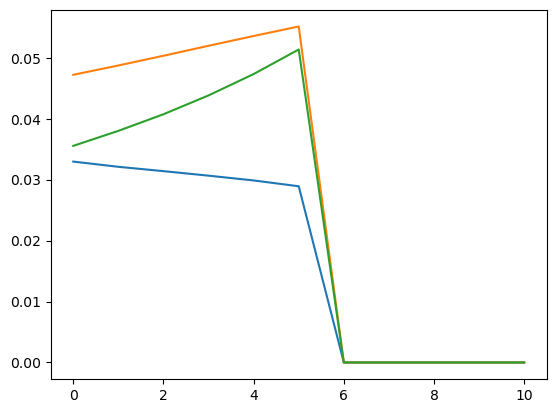

In [214]:
c_impulse = zeros(T, length(ss["y"]), length(ss["a_grid"]))
for t in 1:T
    c_impulse[t, :, :] = 100 * (c[t, :, :] .- ss["c"]) ./ ss["c"]
end
i_ave = argmax(ss["a_grid"] .> ss["A"])

for e in (1, 4, 7)
    plot(c_impulse[:, e, i_ave])
end

In [215]:
# Forward iteration to obtain the distribution

D = zeros(T, length(ss["y"]), length(ss["a_grid"]))
D[1, :, :] = ss["D"]

for t in 1:T - 1
    a_i, p_i = get_lottery(a[t, :, :], ss["a_grid"])
    D[t + 1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, p_i)
end

In [218]:
A = zeros(T)
C = zeros(T) 

for t in 1:11
    A[t] = vec(D[t, :, :])' * vec(a[t, :, :])
    C[t] = vec(D[t, :, :])' * vec(c[t, :, :])
end

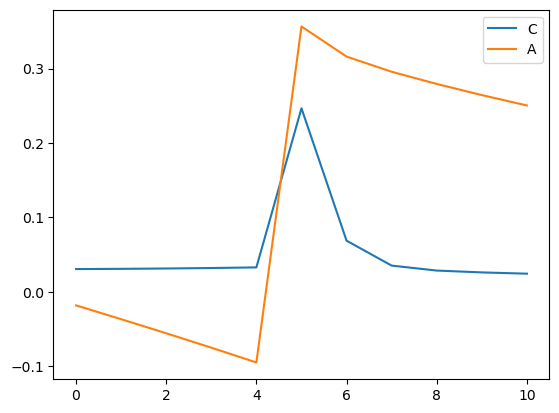

PyObject <matplotlib.legend.Legend object at 0x000001CD02C78670>

In [219]:
C_impulse = 100 * (C .- ss["C"]) ./ ss["C"]
A_impulse = 100 * (A .- ss["A"]) ./ ss["A"]
plot(C_impulse, label="C")
plot(A_impulse, label="A")
legend()

### Partial Equilibrium: Generalizing for any impulse

In [220]:
"+=

shocks: 
    a dictionary where the keys can be 'y', 'r', or 'beta'
    and the values are of the shape original shape (in ss) * T (horizon)

returns:
    T * n_a * n_e
    representing the margial value function, saving policy, and consumption policy 
    over the shock period
=+"

function policy_impulse(ss, shocks, T)
    
    # store paths of asset and consumption policies
    Va = zeros(T, length(ss["y"]), length(ss["a_grid"]))
    a = zeros(T, length(ss["y"]), length(ss["a_grid"]))
    c = zeros(T, length(ss["y"]), length(ss["a_grid"]))
                
    inputs = [ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis")]
    shock_keys = Dict(
        "y" => 4,
        "r" => 5,
        "beta" => 6
    )
        
    for t in reverse(1:T)
        for key in ("y", "r", "beta")
            if haskey(shocks, key)
                to_change = shock_keys[key]
                delta = shocks[key][t, :]
                if length(size(delta)) == 1 && size(delta)[1] == 1
                    delta = delta[1]
                end
                inputs[to_change] = ss[key] + delta
                Va[t, :, :], a[t, :, :], c[t, :, :] = backward_iteration(inputs...)
            end
        end
        inputs[1] = Va[t, :, :] # use for next turn
    end
        
    return Va, a, c
end  

policy_impulse (generic function with 1 method)

In [221]:
# small test case to verify equivalence 
ys_test = copy(ys)
for t in 1:T
    ys_test[t, :] = ys[t, :] - ss["y"]
end

test_dict = Dict("y" => ys_test)
_, a_alt, c_alt = policy_impulse(ss, test_dict, T)
println(maximum(abs.(c - c_alt)), " ", maximum(abs.(a - a_alt)))

0.0 0.0


### Partial Equilibrium: Generalizing for any distribution

In [222]:
"+=
Starting at the steady state at t = 1
Roll forward to period T
=+"

function distribution_impulse(ss, a, T)
    
    D = zeros(size(a)...)
    D[1, :, :] = ss["D"]
    for t in 1:T-1
        a_i, a_pi = get_lottery(a[t, :, :], ss["a_grid"])
        D[t + 1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, a_pi)
    end
    
    return D
end

distribution_impulse (generic function with 1 method)

In [223]:
"+=
Computing aggregate consumption and savings over 1:T
=+"

function household_impulse(ss, shocks, T)
    
    Va, a, c = policy_impulse(ss, shocks, T)
    D = distribution_impulse(ss, a, T)
    A = zeros(T)
    C = zeros(T)
    
    for t in 1:T
        A[t] = vec(a[t, :, :])' * vec(D[t, :, :]) #really is like asset saved for the next period? 
        C[t] = vec(c[t, :, :])' * vec(D[t, :, :])
    end
    
    return Dict("D" => D,
        "Va" => Va,
        "a" => a,
        "c" => c,
        "A" => A, 
        "C" => C
        )
    end

household_impulse (generic function with 1 method)

In [224]:
impulse = household_impulse(ss, test_dict, T)

Dict{String, Array{Float64}} with 6 entries:
  "A"  => [1.6642, 1.66389, 1.66358, 1.66325, 1.66292, 1.67044, 1.66977, 1.6694…
  "c"  => [0.141369 0.250366 … 2.02736 3.0012; 0.141369 0.250366 … 2.02742 3.00…
  "C"  => [1.00447, 1.00447, 1.00447, 1.00448, 1.00449, 1.00664, 1.00485, 1.004…
  "D"  => [0.0152463 0.0886728 … 8.57025e-5 3.59922e-7; 0.0152463 0.0886728 … 8…
  "a"  => [0.0 0.0 … 0.435587 1.3607; 0.0 0.0 … 0.435529 1.36062; … ; 0.0 0.0 ……
  "Va" => [7.09135 4.00414 … 0.494485 0.334033; 7.09135 4.00414 … 0.494471 0.33…

In [225]:
println(maximum(abs.(C - impulse["C"])), " ", maximum(abs.(A - impulse["A"])))

0.0 0.0


### Another example - return shocks

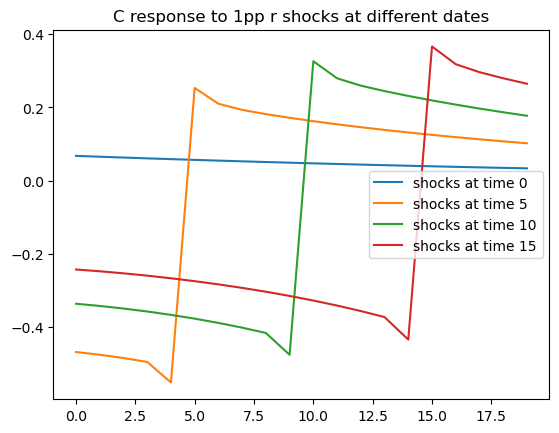

PyObject <matplotlib.legend.Legend object at 0x000001CD02CA74C0>

In [226]:
for t in (1, 6, 11, 16)
    r_shock = zeros(20, 1)
    r_shock[t, 1] = 0.01 
    r_dict = Dict("r" => r_shock)
    plot(100 .* (household_impulse(ss, r_dict, 20)["C"] .- ss["C"]) ./ ss["C"], label = "shocks at time $(t-1)")
end

title("C response to 1pp r shocks at different dates")
legend()
    

### General Equilibrium

In [227]:
B = 5.6
tau = ss["r"] * B
e = ss["y"]
beta_ge = 0.9877855433498467 # using their caliberated beta

0.9877855433498467

In [228]:
function ge_shell(beta_guess)
    # wrapper for root finder
    ss_ge_temp = steady_state(ss["Pi"], ss["a_grid"], (1 - tau) .* e, ss["r"], beta_guess, ss["eis"])
    return 5.6 - ss_ge_temp["A"]
end

ge_shell (generic function with 1 method)

In [229]:
# beta_ge_own = find_zero(ge_shell, (0.98, 0.995), Bisection())

In [230]:
# 5.6 - steady_state(ss["Pi"], ss["a_grid"], (1 - tau) .* e, ss["r"], beta_ge_own, ss["eis"])["A"]

In [231]:
ss_ge = steady_state(ss["Pi"], ss["a_grid"], (1 - tau) .* e, ss["r"], beta_ge, ss["eis"])

Dict{String, Any} with 14 entries:
  "a_pi"   => [1.0 1.0 … 0.217793 0.216538; 1.0 1.0 … 0.21782 0.216564; … ; 0.0…
  "c"      => [0.13939 0.14408 … 119.77 125.457; 0.246861 0.25155 … 119.889 125…
  "C"      => 1.0
  "a_i"    => [1.0 1.0 … 498.0 499.0; 1.0 1.0 … 498.0 499.0; … ; 96.0 97.0 … 49…
  "a_grid" => [0.0, 0.0046779, 0.00939966, 0.0141658, 0.0189769, 0.0238334, 0.0…
  "r"      => 0.0025
  "a"      => [0.0 0.0 … 9440.93 9899.68; 0.0 0.0 … 9440.92 9899.67; … ; 0.7563…
  "eis"    => 1
  "y"      => [0.13939, 0.246861, 0.437192, 0.77427, 1.37124, 2.42847, 4.30083]
  "A"      => 5.6
  "D"      => [0.0131548 7.68982e-5 … 7.71689e-106 5.5794e-108; 0.0692791 0.000…
  "Va"     => [7.19204 6.95795 … 0.00837023 0.00799076; 4.06099 3.98528 … 0.008…
  "beta"   => 0.987786
  "Pi"     => [0.927305 0.0704282 … 1.80817e-9 3.8147e-12; 0.011738 0.928048 … …

In [232]:
T = 300
Xs = 1 .+ 0.01 .* 0.95 .^ collect(0:299) # 1% AR(1) shock with rho = 0.95

300-element Vector{Float64}:
 1.01
 1.0095
 1.009025
 1.00857375
 1.0081450625
 1.007737809375
 1.00735091890625
 1.0069833729609374
 1.0066342043128906
 1.006302494097246
 1.0059873693923838
 1.0056880009227647
 1.0054036008766263
 ⋮
 1.0000000038405934
 1.0000000036485637
 1.0000000034661354
 1.0000000032928287
 1.0000000031281873
 1.000000002971778
 1.000000002823189
 1.0000000026820295
 1.000000002547928
 1.0000000024205318
 1.000000002299505
 1.00000000218453

In [233]:
pi = sum(ss_ge["D"], dims = 2) # steady state distribution produced by ss_ge

7×1 Matrix{Float64}:
 0.015625000000000215
 0.09375000000000137
 0.23437500000000366
 0.31250000000000483
 0.2343750000000037
 0.09375000000000139
 0.01562500000000021

In [234]:
function impulse_map(rs, Xs) 
    
    # constructing shocks
    taus = rs * B # balancing budget r_t * B = tau_t
    y_shocks = (Xs .- taus) * e'
    for t in 1:length(rs)
        y_shocks[t, :] = y_shocks[t, :] - ss_ge["y"]
    end
    r_shocks = rs .- ss_ge["r"]
    shock_dict = Dict(
            "r" => r_shocks,
            "y" => y_shocks
        )
    
    impulse = household_impulse(ss_ge, shock_dict, length(rs))
    
    return impulse["A"] .- B, impulse
end

impulse_map (generic function with 1 method)

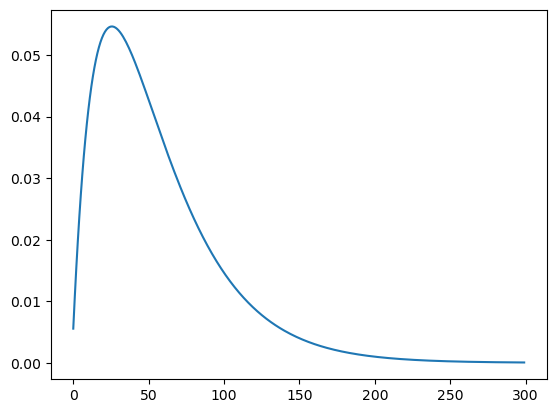

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001CD02D37070>

In [235]:
asset_mkt_errors, _ = impulse_map(fill(ss_ge["r"], 300), Xs)
plot(asset_mkt_errors)

In [236]:
# skipping some sections about why gradually lowering the interest rate is too slow

### Brute-force computation of Jacobians

In [237]:
T = 300

300

In [238]:
J = zeros(T, T)
h = 1e-4 # small shock to r 
no_shock = impulse_map(fill(ss_ge["r"], 300), fill(1, 300))[1]
for tshock in 1:T
    r_shock = fill(ss_ge["r"], 300)
    r_shock[tshock] = ss_ge["r"] + h
    J[:, tshock] = (impulse_map(r_shock, fill(1, 300))[1] - no_shock) ./ h
    println(tshock)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [239]:
J #checks out

300×300 Matrix{Float64}:
 0.4851       0.953788     0.904036     …   7.43212e-6    7.13299e-6
 0.553613     1.38875      1.81784          1.50319e-5    1.44268e-5
 0.610686     1.41615      2.21491          2.28093e-5    2.18913e-5
 0.659018     1.4368       2.20807          3.0775e-5     2.95363e-5
 0.700167     1.45186      2.19736          3.89396e-5    3.73723e-5
 0.735411     1.46211      2.18322      …   4.73142e-5    4.54098e-5
 0.765433     1.46849      2.16614          5.59102e-5    5.36598e-5
 0.790779     1.47143      2.14683          6.47396e-5    6.21337e-5
 0.811945     1.47125      2.12552          7.38145e-5    7.08433e-5
 0.829359     1.46831      2.10241          8.31478e-5    7.98009e-5
 0.843404     1.46289      2.07773      …   9.27526e-5    8.9019e-5
 0.854446     1.45527      2.05167          0.000102643   9.85108e-5
 0.862811     1.44573      2.02441          0.000112832   0.00010829
 ⋮                                      ⋱                
 0.000720046  0.00095

* The brute force method is just perturbing by dh = 1e-4 and computing an approximate of the derivate
* Repeats for shocks happening at all time horizons

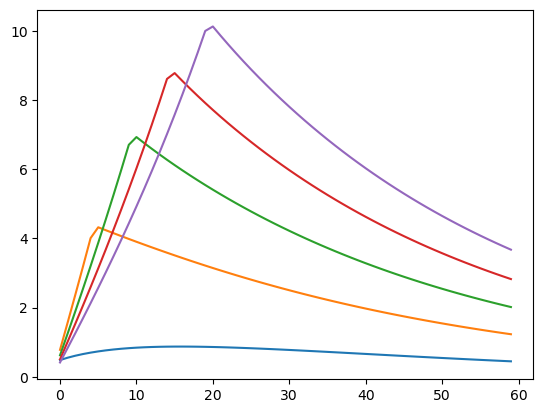

In [240]:
for t in (1, 6, 11, 16, 21)
    plot(J[1:60, t])
end

Asset market clearing with a tolerance of 1.0e-10 on iteration 7


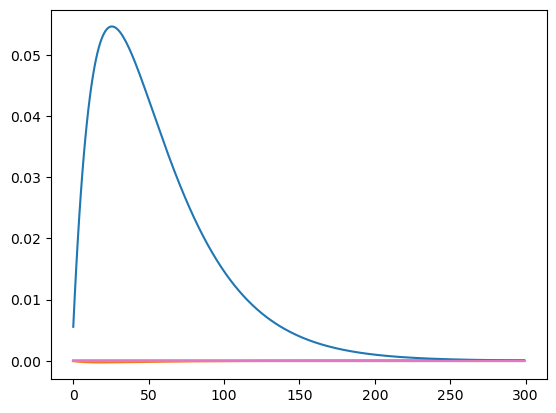

In [241]:
# Newton's to improve upon root finding for finding the market clearing interest rate

rs = fill(ss_ge["r"], T)
Jbar = J[1:T-1, 2:T]
tol = 1e-10

for it in 1:30
    ame, imp = impulse_map(rs, Xs)
    plot(ame)
    err = maximum(abs.(ame[1:T - 1]))
    if err < 1e-10
        println("Asset market clearing with a tolerance of $tol on iteration $it")
        break
    end
    rs[2:T] = rs[2:T] - Jbar \ ame[1:T - 1]
end

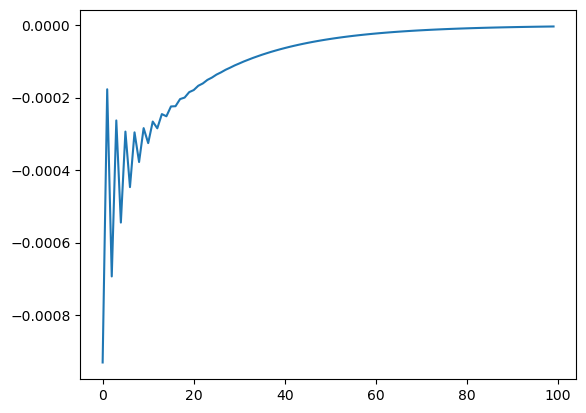

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001CD02CF6FA0>

In [242]:
rs_adjustment = rs[2:101] .- ss_ge["r"]
plot(rs_adjustment)

### The fake news algorithm

Claim 1: All that matters is time until shock.

 (not really) a pf: Imagine going through the steps of derivation for the consumption response, but now arbitrarily shift all indicies by the same constant. All the equalities still hold. $\square$

In [243]:
# using Claim 1 to build the Jacobian

r_late_shock = fill(ss_ge["r"], T)
r_late_shock[T] += h
da = impulse_map(r_late_shock, fill(1, T))[2]["a"]

300×7×500 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 0.0  0.0  0.0  0.0181692  0.210107  0.756392  1.9658
 ⋮                                   ⋮         
 0.0  0.0  0.0  0.0181974  0.21019   0.756522  1.96599
 0.0  0.0  0.0  0.0182012  0.210195  0.756527  1.96599
 0.0  0.0  0.0  0.0182059  0.210199  0.756533  1.966
 0.0  0.0  0.0  0.018211   0.210204  0.756538 

In [244]:
for t in 1:T
    da[t, :, :] -= ss_ge["a"]
end

* da[t, :, :] represents the difference between the consumption policy given
the shock at period T, anticipated at period t, versus the steady state policy

In [245]:
"+=
This is just a simple function to populate along the first axis of to_fill
with a matrix to be filled; in our application the first axis is usually time
=+"

function populate_time(to_fill, fill)
    for t in 1:size(to_fill)[1]
        to_fill[t, :, :] = fill
    end
    return to_fill
end

populate_time (generic function with 1 method)

In [248]:
# weird bug, using Sophia's version with edits for the moment until I figure out what is wrong

@time begin
    J_alt = Array{Float64}(undef, T, T)
    
    a_ss = zeros(T, size(ss_ge["a"])...)
    a_ss = populate_time(a_ss, ss_ge["a"])
    
    for s in 0:T-1
        
        a = copy(a_ss)
        # this is taking advantage of the symmetry; the adjustment at T - s
        # to a time T shock is the same as the adjustment at time 1 to a time
        # s + 1 shock 
        
        a[1:s+1, :, :] += da[T-s:end, :, :]
        
        # starting with this set of asset policies, obtain distributions for all 1:T
        D = distribution_impulse(ss_ge, a, T)
        # $sum_{types}(holdings_{type} * density_{type}$
        A = sum(a .* D, dims = (2, 3))
        J_alt[:, s+1] = (A .- B .- no_shock) ./ h # NOTE: no_shock is slightly different from the Python version
    end
end

273.705984 seconds (1.36 M allocations: 24.663 GiB, 0.75% gc time)


In [249]:
maximum(abs.(J_alt - J))

2.4868995751603507e-10

Insight 2, understanding the difference between $J_{t, s}$ and $J_{t-1, s-1}$

* While there is no policy difference, the difference between these two values 
comes from the fact that t has an extra period to respond in the perfect foresight
model

* Define $F_{t, s}$ to be this difference

In [250]:
F = copy(J)
F[2:end, 2:end] -= J[1:end - 1, 1:end - 1]
F

300×300 Matrix{Float64}:
 0.4851       0.953788     0.904036     …  7.7438e-6   7.43212e-6  7.13299e-6
 0.553613     0.903655     0.864052        7.59369e-6  7.28805e-6  6.99472e-6
 0.610686     0.862541     0.826159        7.44683e-6  7.1471e-6   6.85944e-6
 0.659018     0.826114     0.791918        7.30305e-6  7.00911e-6  6.727e-6
 0.700167     0.792844     0.760558        7.16222e-6  6.87394e-6  6.59726e-6
 0.735411     0.761941     0.731355     …  7.02425e-6  6.74151e-6  6.47018e-6
 0.765433     0.733081     0.704028        6.88902e-6  6.61172e-6  6.34561e-6
 0.790779     0.705995     0.678335        6.75643e-6  6.48449e-6  6.22348e-6
 0.811945     0.680472     0.654091        6.62644e-6  6.35973e-6  6.10372e-6
 0.829359     0.656361     0.63116         6.499e-6    6.2374e-6   5.98634e-6
 0.843404     0.633531     0.609423     …  6.37399e-6  6.11742e-6  5.87119e-6
 0.854446     0.61187      0.588778        6.2513e-6   5.99966e-6  5.75818e-6
 0.862811     0.591282     0.569138      

In [251]:
ss_ge["a_i"]

7×500 Matrix{Float64}:
   1.0    1.0    1.0    1.0    2.0  …  495.0  496.0  497.0  498.0  499.0
   1.0    1.0    1.0    1.0    2.0     495.0  496.0  497.0  498.0  499.0
   1.0    1.0    1.0    1.0    2.0     495.0  496.0  497.0  498.0  499.0
   4.0    5.0    6.0    7.0    8.0     495.0  496.0  497.0  498.0  499.0
  38.0   39.0   39.0   40.0   41.0     495.0  496.0  497.0  498.0  499.0
  96.0   97.0   97.0   98.0   98.0  …  495.0  496.0  497.0  498.0  499.0
 159.0  159.0  159.0  159.0  159.0     495.0  496.0  497.0  498.0  499.0

In [269]:
@time begin
    F_alt = zeros(T, T)
    for s in 0:T-1
        # calculate impulse response to anticipation of date-s shock at date 0
        a = copy(a_ss)
        a[1, :, :] = a[1, :, :] + da[T - s, :, :]
        D = distribution_impulse(ss_ge, a, T)
        A = sum(a .* D, dims=(2, 3))
        F_alt[:, s + 1] = (A .- B .- no_shock) ./ h
    end
    maximum(abs.(F_alt - F))
end

250.336521 seconds (1.36 M allocations: 21.148 GiB, 0.68% gc time)


2.442566288118897e-10

In [270]:
function J_from_F(F)
    J = copy(F)
    for t in 2:size(F)[1]
        J[2:end, t] += J[1:end - 1, t - 1]
    end
    return J
end

J_from_F (generic function with 1 method)

In [271]:
maximum(abs.(J_from_F(F_alt) - J))

0.0017242316019405735

* skip insight 3; jumping straight to the whole algo

In [272]:
ss_ge

Dict{String, Any} with 14 entries:
  "a_pi"   => [1.0 1.0 … 0.217793 0.216538; 1.0 1.0 … 0.21782 0.216564; … ; 0.0…
  "c"      => [0.13939 0.14408 … 119.77 125.457; 0.246861 0.25155 … 119.889 125…
  "C"      => 1.0
  "a_i"    => [1.0 1.0 … 498.0 499.0; 1.0 1.0 … 498.0 499.0; … ; 96.0 97.0 … 49…
  "a_grid" => [0.0, 0.0046779, 0.00939966, 0.0141658, 0.0189769, 0.0238334, 0.0…
  "r"      => 0.0025
  "a"      => [0.0 0.0 … 9440.93 9899.68; 0.0 0.0 … 9440.92 9899.67; … ; 0.7563…
  "eis"    => 1
  "y"      => [0.13939, 0.246861, 0.437192, 0.77427, 1.37124, 2.42847, 4.30083]
  "A"      => 5.6
  "D"      => [0.0131548 7.68982e-5 … 7.71689e-106 5.5794e-108; 0.0692791 0.000…
  "Va"     => [7.19204 6.95795 … 0.00837023 0.00799076; 4.06099 3.98528 … 0.008…
  "beta"   => 0.987786
  "Pi"     => [0.927305 0.0704282 … 1.80817e-9 3.8147e-12; 0.011738 0.928048 … …

In [273]:
curlyE = expectation_functions(ss_ge["a"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"], T)

300×7×500 Array{Float64, 3}:
[:, :, 1] =
 0.0          0.0          0.0         …  0.210107  0.756392   1.9658
 7.59857e-7   3.10432e-5   0.00104658     0.414777  1.47328    3.8029
 6.89387e-6   0.000158273  0.00325115     0.614311  2.15263    5.51925
 2.75182e-5   0.000448784  0.00672012     0.808899  2.79622    7.12219
 7.60457e-5   0.000971077  0.0115502      0.998679  3.40571    8.61851
 0.000169945  0.0017942    0.0178214   …  1.18376   3.98266   10.0145
 0.00033045   0.00298688   0.0256017      1.36422   4.52851   11.3161
 0.000582233  0.00461677   0.0349438      1.54015   5.04467   12.5287
 0.000953046  0.00674971   0.0458886      1.7116    5.53244   13.6575
 0.00147334   0.00944918   0.0584642      1.87866   5.99308   14.7072
 0.00217589   0.0127758    0.0726874   …  2.04137   6.4278    15.6825
 0.00309537   0.0167868    0.0885658      2.1998    6.83774   16.5875
 0.00426799   0.0215358    0.106097       2.354     7.22398   17.4261
 ⋮                                     ⋱      

In [274]:
F = zeros(T, T)
D1_noshock = forward_iteration(ss_ge["D"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"])

for s in 0:T - 1
    F[1, s + 1] = dot(ss_ge["D"], da[T-s, :, :]) ./ h
    
    # change in D_1 from this change
    a_i_shocked, a_pi_shocked = get_lottery(ss_ge["a"] + da[T - s, :, :], ss_ge["a_grid"])
    dD1 = forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock
    
    # use expectation vectors to project effect on aggregate
    F[2:end, s + 1] = (reshape(curlyE[1:T-1, : , :], T-1, :) * vec(dD1)) / h
end

J_alt = J_from_F(F)

300×300 Matrix{Float64}:
 0.4851       0.953788     0.904036     …   7.43213e-6    7.133e-6
 0.553613     1.38876      1.81783          1.50319e-5    1.44268e-5
 0.610686     1.41613      2.21488          2.28093e-5    2.18913e-5
 0.659018     1.43677      2.20801          3.0775e-5     2.95363e-5
 0.700167     1.45184      2.19729          3.89396e-5    3.73723e-5
 0.735411     1.46208      2.18315      …   4.73142e-5    4.54098e-5
 0.765433     1.46846      2.16607          5.59102e-5    5.36598e-5
 0.790779     1.4714       2.14676          6.47396e-5    6.21337e-5
 0.811945     1.47122      2.12545          7.38145e-5    7.08434e-5
 0.829359     1.46828      2.10235          8.31478e-5    7.98009e-5
 0.843404     1.46286      2.07766      …   9.27526e-5    8.9019e-5
 0.854446     1.45525      2.0516           0.000102643   9.85108e-5
 0.862811     1.4457       2.02435          0.000112832   0.00010829
 ⋮                                      ⋱                
 0.000720046  0.0009566

In [275]:
maximum(abs.(J - J_alt))

0.001724232436021822

* The authors acknowledge this error

### Generalizing the code

In [561]:
"+=
Unpack the merged dictionary and call backward iteration
Returns outputs from backward iteration
=+"

function unpack_backiter(merged_dict)
    # Va, Pi, a_grid, y, r, beta, eis
    keys = ["Va", "Pi", "a_grid", "y", "r", "beta", "eis"]
    arguments = [merged_dict[key] for key in keys]
    return backward_iteration(arguments...)
end

unpack_backiter (generic function with 1 method)

In [562]:
function step1_backward(ss, shock, T, h)
    # preliminaries: D_1 with no shock, ss inputs to backward_iteration
    D1_noshock = forward_iteration(ss["D"], ss["Pi"], ss["a_i"], ss["a_pi"])
    ss_inputs = Dict(k => ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis"))
    
    # allocate space for results
    curlyY = Dict("A" => zeros(T), "C" =>  zeros(T))
    curlyD = zeros(T, size(ss["D"])...)
    
    Va = ss["Va"]
    
    # backward iterate
    for s in 1:T
        if s == 1
            # at horizon of s=1, 'shock' actually hits, override ss_inputs with shock
            shocked_inputs = Dict(k => ss[k] + h .* shock[k] for k in keys(shock))
            Va, a, c = unpack_backiter(merge(ss_inputs, shocked_inputs))
        else
            # now the only effect is anticipation, so it's just Va being different
            Va, a, c = unpack_backiter(merge(ss_inputs, Dict("Va" => Va)))
        end # correct until here
        
        # aggregate effects on A and C
        curlyY["A"][s] = dot(ss["D"], a - ss["a"]) ./ h
        curlyY["C"][s] = dot(ss["D"], c - ss["c"]) ./ h
        
        # what is effect on one-period-ahead distribution?
        a_i_shocked, a_pi_shocked = get_lottery(a, ss["a_grid"])
        curlyD[s, :, :] = (forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock) ./ h
    end
    
    return curlyY, curlyD
end

step1_backward (generic function with 1 method)

In [563]:
# mistakes in here somewhere; need to debug

function jacobian(ss, shocks, T)
    # step 1 for all shocks i, allocate to curlyY[o][i] and curlyD[i]
    curlyY = Dict("A" => Dict(), "C" => Dict())
    curlyD = Dict()
    for (i, shock) in shocks
        curlyYi, curlyD[i] = step1_backward(ss, shock, T, 1E-4)
        curlyY["A"][i], curlyY["C"][i] = curlyYi["A"], curlyYi["C"]
    end
    
    # step 2 for all outputs o of interest (here A and C)
    curlyE = Dict()
    for o in ("A", "C")
        curlyE[o] = expectation_functions(ss[lowercase(o)], ss["Pi"], ss["a_i"], ss["a_pi"], T-1)
    end
    
    # steps 3 and 4: build fake news matrices, convert to Jacobians
    Js = Dict("A" => Dict(), "C" => Dict())
    for o in keys(Js)
        for i in keys(shocks)
            F = Array{Float64}(undef, (T, T))
            F[1, :] = curlyY[o][i]
            F[2:end, :] = reshape(curlyE[o], T-1, :) * reshape(curlyD[i], T, :)'
            Js[o][i] = J_from_F(F)
        end
    end
    
    return Js
end

jacobian (generic function with 1 method)

In [566]:
@time begin
    shocks = Dict("r_direct" => Dict("r" => 1), "X" => Dict("y" => e), "T" => Dict("y" => ones(size(e))))
    Js = jacobian(ss_ge, shocks, T)
end

  3.742965 seconds (208.63 k allocations: 701.692 MiB, 1.31% gc time)


Dict{String, Dict{Any, Any}} with 2 entries:
  "A" => Dict("X"=>[0.889387 -0.03564 … -2.47446e-7 -2.37486e-7; 0.856077 0.857…
  "C" => Dict("X"=>[0.110613 0.03564 … 2.47446e-7 2.37486e-7; 0.0355335 0.10699…

In [567]:
J_alt2 = Js["A"]["r_direct"] - B.*Js["A"]["X"]
# compare to original brute-force Jacobian, fake-news Jacobian
maximum(abs.(J_alt2 - J)), maximum(abs.(J_alt2 - J_alt))

(0.0016709859168511088, 0.0002660100579383595)

## Taking Stock

* Now we have implemented the general fake news algorithm 
* Need to write better documentation sinc ethe inputs can be quite complex
* Will move onto reading and deriving results from the paper for now

As to why the time is not as fast as the Python notebook:
* Difference between machines
* They optimized the lottery assignment; we are still using a more brute forced method